In [18]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import time
from scipy.spatial.distance import mahalanobis,euclidean
from sklearn import metrics
from scipy.spatial.distance import mahalanobis
import heapq

# Load data

In [24]:
batch_num = 8
hidden_num = 15
step_num = 3
elem_num = 34
init_wins = 10000

names = [str(x) for x in range(elem_num)] +["label"]
smtp = pd.read_csv("C:/Users/Bin/Desktop/Thesis/dataset/smtp.csv",names=names,skiprows=step_num*init_wins)
batches = smtp.shape[0]//step_num//batch_num
test_set = smtp.iloc[:batches*batch_num*step_num,:-1]
labels =smtp.iloc[:batches*batch_num*step_num,-1]

ts = test_set.as_matrix().reshape(batches,batch_num,step_num,elem_num)
test_set_list = [ts[a] for a in range(batches)]

In [28]:
labels[labels!="normal"] = "anomaly"

In [29]:
del smtp
del test_set

In [30]:
wins = batches * batch_num
# figure out anomaly windows
buffer = [labels[i*step_num:(i+1)*step_num] for i in range(0,labels.size//step_num)]
anomaly_index = []
count = 0
for buf in buffer:
    if "anomaly" in buf.tolist():
        anomaly_index.append(count)
    else:
        pass
    count +=1
print(anomaly_index)

expert = ["normal"]*wins
for x in anomaly_index:
    expert[x] = "anomaly"

[622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 4545, 5368, 6633, 7315, 7316, 7317, 7318, 7319, 7320, 7321, 7322, 7323, 7324, 7325, 7326, 7327, 7328, 7329, 7330, 7331, 7332, 7333, 7334, 7335, 7336, 7337, 7338, 7339, 7340, 7341, 7342, 7343, 7344, 7345, 7346, 7347, 7348, 7349, 7350, 7351, 7352, 7353, 7354, 7355, 7356, 7357, 7358, 7359, 7360, 7361, 7362, 7363, 7364, 7365, 7366, 7367, 7368, 7369, 7370, 7371, 7372, 7373, 7374, 7375, 7376, 7377, 7378, 7379, 7380, 7381, 7382, 8696, 8697, 8698, 8699, 10024, 10755, 10756, 12804, 13466, 15565, 15566, 15567, 15568, 15569, 15570, 15571, 15572, 15573, 15574, 15575, 15576, 15577, 15578, 15579, 15580, 15581, 15582, 15583, 15584, 15585, 15586, 15587, 15588, 15589,

# Load Model

In [7]:
modelpath_root ="C:/Users/Bin/Desktop/Thesis/models/smtp_8_15_3/"#"C:/Users/Bin/Desktop/Thesis/models/smtp_multivariate/"
modelmeta_p = modelpath_root + "_8_15_3_para.ckpt.meta"#"_1_5_100_para.ckpt.meta"

sess = tf.Session()
saver = tf.train.import_meta_graph(modelmeta_p) # load trained gragh, but without the trained parameters
saver.restore(sess,tf.train.latest_checkpoint(modelpath_root))
graph = tf.get_default_graph()

p_input = graph.get_tensor_by_name("p_input:0")
p_inputs = [tf.squeeze(t, [1]) for t in tf.split(p_input, step_num, 1)] 
p_is_training = graph.get_tensor_by_name("is_training_:0")

input_= tf.transpose(tf.stack(p_inputs), [1, 0, 2])    
output_ = graph.get_tensor_by_name("decoder/output_:0")

tensor_mu = graph.get_tensor_by_name("mu:0")
tensor_sigma = graph.get_tensor_by_name("sigma:0")
tensor_threshold = graph.get_tensor_by_name("threshold:0")

loss_ = graph.get_tensor_by_name("decoder/loss:0")
train_ = graph.get_operation_by_name("cond/train_")

mu = sess.run(tensor_mu)
sigma = sess.run(tensor_sigma)
threshold = sess.run(tensor_threshold)

INFO:tensorflow:Restoring parameters from C:/Users/Bin/Desktop/Thesis/models/smtp_8_15_3/_8_15_3_para.ckpt


In [8]:
print(mu.shape,sigma.shape,threshold)

(34,) (34, 34) 0.0235452


# Online Phase (With expert)

In [9]:
def local_preprocessing(batchdata):
    # input batchdata with shape : [batch_num, step_num, elem_num]
    # minmax scaler on window level
    df = pd.DataFrame()
    
    for window in batchdata:
        
        scaler = MinMaxScaler()
        scaler.fit(window)
        new_win = scaler.transform(window)
        df = pd.concat((df, pd.DataFrame(new_win)),axis=0) if df.size!=0 else pd.DataFrame(new_win)
    return df.as_matrix().reshape(batchdata.shape)

    

In [10]:
def scoring(err,mu,sigma):
    
    scores = []
    for e in err:
        scores.append(mahalanobis(e,mu,sigma))

    return scores

In [11]:
def update_parameter(errBuffer,mu,sigma,eta,threshold,score,label):       
        tmp_errBuffer = errBuffer[-3:] if len(errBuffer)>3 else errBuffer
        err_vec_array = np.array(tmp_errBuffer)
        # for univariate  data
        __mu = np.mean(err_vec_array.ravel())
        mu = mu*eta + __mu*(1-eta)

        __sigma =np.var(err_vec_array.ravel())
        sigma = __sigma
        
        __thresold = scores.min()
        f = 0
        for t in range(int(scores.min()*100),int(scores.max()*100),5):
            fbeta,_, _ = evaluate(t/100,score,label)
            __thresold = t/100 if fbeta>f else __thresold
            
        threshold = threshold*eta + __thresold*(1-eta)
        return mu,sigma,threshold

In [12]:
def get_musigma(err_nbuf,mu,sigma):       
    
        err_vec_array = np.array(err_nbuf)
        # for multivariate  data
        mu = np.mean(err_vec_array,axis=0)
        sigma = np.cov(err_vec_array.T)
        return mu, sigma

In [13]:
def get_threshold(normal_score, abnormal_score):
        upper = np.median(np.array(abnormal_score))
        lower = np.median(np.array(normal_score)) 
        scala = 20
        delta = (upper-lower) / scala
        candidate = lower
        threshold = 0
        result = 0

        def evaluate(threshold,normal_score,abnormal_score):

            beta = 0.5
            tp = np.array(abnormal_score)[np.array(abnormal_score)>threshold].size
            fp = len(abnormal_score)-tp
            fn = np.array(normal_score)[np.array(normal_score)>threshold].size
            tn = len(normal_score)- fn

            if tp == 0: return 0

            P = tp/(tp+fp)
            R = tp/(tp+fn)
            fbeta= (1+beta*beta)*P*R/(beta*beta*P+R)
            return fbeta 

        for _ in range(scala):
            r = evaluate(candidate,normal_score,abnormal_score)
            if r > result:
                result = r 
                threshold = candidate
            candidate += delta 
        return threshold

In [14]:
def plot_roc(fpr,tpr,auc):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' %auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

# Without retraining

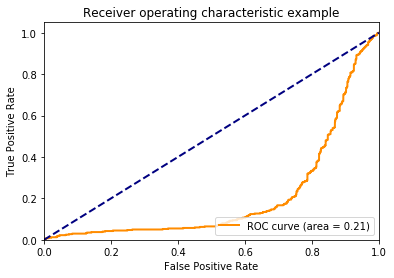

In [48]:
count = 0
n_buf = []
a_buf = []

y = []
output=[]
box = []
err_nbuf = []
err_abuf = []
all_scores = []

for l in labels:
    if l == "normal":
        y +=[0]
    else: 
        y +=[1]
for data in test_set_list:
    
        prediction = []
        df = local_preprocessing(data)
        (input_n, output_n) = sess.run([input_, output_], {p_input: df, p_is_training: False})

        err = abs(input_n-output_n).reshape(-1,elem_num)
        
        box.append(err.reshape(-1,))
        
        scores = scoring(err,mu,sigma)
        scores = pd.Series(scores)
        
        all_scores.append(scores)
#        output +=  [np.array(heapq.nlargest(10,scores)).mean()]
        output += [ss.max() for ss in scores.as_matrix().reshape(batch_num,step_num)]
        pred = [scores[b*step_num:(b+1)*step_num] for b in range(batch_num)]
        label = [expert[count*batch_num+b]for b in range(batch_num)]
        e = [err.reshape(-1,elem_num)]
        for index,value in enumerate(pred):
            if value[value>threshold].size>=0: 
                if label[index] == "anomaly":
                    #print("TP")                 
                    a_buf.append(df[index])
                    #err_abuf.append(e[index])
                    #err_abuf = err_abuf + e[index] if len(err_abuf) != 0 else e[index]
                else:
                    #print("FP")
                    #err_nbuf.append(e[index])
                    #err_nbuf = err_nbuf + e[index] if len(err_nbuf) != 0 else e[index]
                    n_buf.append(df[index])
            else:               
                if label[index] == "anomaly":             
                    #print("FN")
                    a_buf.append(df[index])
                    #err_abuf.append(e[index])
                    #err_abuf = err_abuf + e[index] if len(err_abuf) != 0 else e[index]
                else:
                    pass
                    #err_nbuf.append(e[index])
                    #err_nbuf = err_nbuf + e[index] if len(err_nbuf) != 0 else e[index]
                    #print("TN")
        count +=1
        

        
#        if len(n_buf)>=30 and len(a_buf)>=10:
        if len(n_buf) >= batch_num*step_num*50000000:
            print("retrain at %d batch"%count)
            loss_list_all=[]

            datalist = np.array(n_buf[:]).reshape(-1,batch_num,step_num,elem_num)
            validation_list_n = np.array(n_buf[6:]).reshape(-1,batch_num,step_num,elem_num)
            validation_list_a = np.array(a_buf).reshape(-1,batch_num,step_num,elem_num)
            
            for i in range(70):
                
                loss_list=[]
                for data in datalist:
                    (loss, _) = sess.run([loss_, train_], {p_input: data,p_is_training : True})
                    loss_list.append(loss)
                #print('Retrain-iter %d:' % (i + 1), np.array(loss_list).mean())
                loss_list_all.append( np.array(loss_list).mean()) 
            

            err_nbuf_tmp = np.array(err_nbuf).reshape(-1,elem_num)
            mu,sigma = get_musigma(err_nbuf_tmp,mu,sigma)

            normal_score = []
            abnormal_score = []
            

            print("Parameters updated!")
            pd.Series(loss_list_all).plot(title="Loss")
            n_buf = []
            a_buf = []
            err_buf = []
                
fpr, tpr, thresholds = metrics.roc_curve(expert, output, pos_label="anomaly")
auc = metrics.auc(fpr, tpr)
#print(fpr,tpr,thresholds,auc)
plot_roc(fpr,tpr,auc)

plt.show()

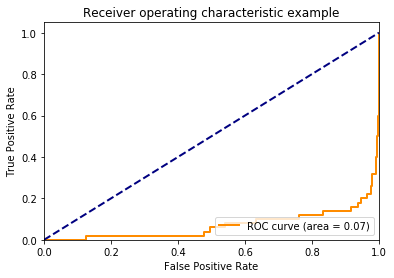

In [40]:
fpr, tpr, thresholds = metrics.roc_curve(labels[::24], output, pos_label="anomaly")
auc = metrics.auc(fpr, tpr)
#print(fpr,tpr,thresholds,auc)
plot_roc(fpr,tpr,auc)

plt.show()

# With retraining

0
retrain at 31 batch
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
Parameters updated! new threshold 0.052
retrain at 62 batch
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
Parameters updated! new threshold 0.052
retrain at 94 batch
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
Parameters updated! new threshold 0.052
100
retrain at 125 batch
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
Parameters updated! new threshold 0.052
retrain at 156 batch
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
Parameters updated! new threshold 0.052
retrain at 187 batch
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
Parameters updated! new threshold 0.052
200
retrain at 220 batch
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
Parameters updated! new threshold 0.052
retrai

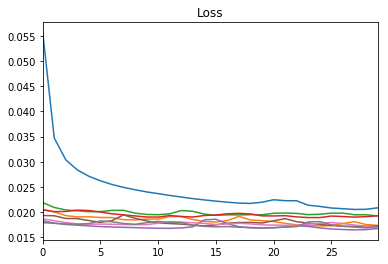

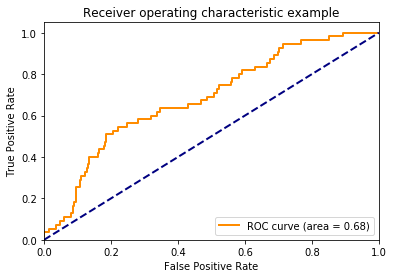

In [21]:
count = 0
n_buf = []
a_buf = []

y = []
output=[]
err_nbuf = []
err_abuf = []
all_scores = []


for l in labels:
    if l == "normal":
        y +=[0]
    else: 
        y +=[1]
for data in test_set_list:
        if count % 100 == 0:
            print(count)
            
        prediction = []
        df = local_preprocessing(data)
        (input_n, output_n) = sess.run([input_, output_], {p_input: df, p_is_training: False})

        err = abs(input_n-output_n).reshape(-1,elem_num)
        
  
        scores = scoring(err,mu,sigma) # (8*30,)
        #scores = pd.Series(scores)
        
        all_scores.append(scores)
#        output +=  [np.array(heapq.nlargest(10,ss)).mean() for ss in scores.as_matrix().reshape(batch_num,step_num)]
        output += [ss.max() for ss in np.array(scores).reshape(batch_num,step_num)]
        pred = [scores[b*step_num:(b+1)*step_num] for b in range(batch_num)]  # (8,30)
        
        label = [expert[count*batch_num+b] for b in range(batch_num)]
        e = err
        
#       for index,value in enumerate(pd.DataFrame(pred)):
        for i in range(pd.DataFrame(pred).shape[0]):#loop batch_num
            index = i
            value=pd.DataFrame(pred).iloc[i,:]
            
            if value[value>threshold].size>=5: 
                if label[index] == "anomaly":
                    #print("TP")                 
                    a_buf += [df[index,x,:] for x in range(step_num)]
                    #err_abuf.append(e[index*step_num:(index+1)*step_num])
                    err_abuf = np.concatenate((err_abuf , e[index*step_num:(index+1)*step_num]),axis=0) if len(err_abuf) != 0 else e[index*step_num:(index+1)*step_num]
                else:
                    #print("FP")
                    #err_nbuf.append(e[index])
                    err_nbuf =np.concatenate((err_nbuf , e[index*step_num:(index+1)*step_num]),axis=0) if len(err_nbuf) != 0 else e[index*step_num:(index+1)*step_num]
                    
                    n_buf += [df[index,x,:] for x in range(step_num)]
            else:               
                if label[index] == "anomaly":             
                    #print("FN")
                    a_buf += [df[index,x,:] for x in range(step_num)]
                    #err_abuf.append(e[index])
                    err_abuf = np.concatenate((err_abuf , e[index*step_num:(index+1)*step_num]),axis=0) if len(err_abuf) != 0 else e[index*step_num:(index+1)*step_num]
                else:
                    
                    #err_nbuf.append(e[index])
                    err_nbuf = np.concatenate((err_nbuf , e[index*step_num:(index+1)*step_num]),axis=0) if len(err_nbuf) != 0 else e[index*step_num:(index+1)*step_num]
                    #print("TN")
        count +=1
        
        
        #n_buf = list(np.concatenate(n_buf,axis=0)) if len(n_buf) != 0 else list(n_buf)
        #a_buf = list(np.concatenate(a_buf,axis=0)) if len(a_buf) != 0 else list(a_buf)
        
        if len(n_buf)>=batch_num*step_num*30 and len(a_buf) !=0:
            while (len(a_buf) < batch_num*step_num):
                a_buf += a_buf
            
            B = len(n_buf) //(batch_num*step_num)
            n_buf = n_buf[:batch_num*step_num*B]
            A = len(a_buf)//(batch_num*step_num)
            a_buf = a_buf[:batch_num*step_num*A]
            
            print("retrain at %d batch"%count)
            loss_list_all=[]

            #datalist = np.array(n_buf).reshape(-1,batch_num,step_num,elem_num)
            datalist = np.array(n_buf[:batch_num*step_num*(B-1)]).reshape(-1,batch_num,step_num,elem_num)
            validation_list_n = np.array(n_buf[batch_num*step_num*(B-1):]).reshape(-1,batch_num,step_num,elem_num)
            validation_list_a = np.array(a_buf).reshape(-1,batch_num,step_num,elem_num)
            
            for i in range(30):
                print(i)
                loss_list=[]
                for data in datalist:
                    (loss, _) = sess.run([loss_, train_], {p_input: data,p_is_training : True})
                    loss_list.append(loss)
                #print('Retrain-iter %d:' % (i + 1), np.array(loss_list).mean())
                loss_list_all.append( np.array(loss_list).mean()) 
            


      

            print("Parameters updated! new threshold %.3f"%threshold)
            pd.Series(loss_list_all).plot(title="Loss")
            n_buf = []
            a_buf = []
            err_buf = []
            err_nbuf = []
            err_abuf = []
                
fpr, tpr, thresholds = metrics.roc_curve(expert, output, pos_label="anomaly")
auc = metrics.auc(fpr, tpr)
#print(fpr,tpr,thresholds,auc)
plot_roc(fpr,tpr,auc)

plt.show()

0.771951219512


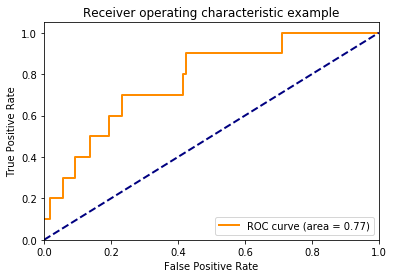

In [30]:
fpr, tpr, thresholds = metrics.roc_curve(expert[62*8:94*8], output[62*8:94*8], pos_label="anomaly")
auc = metrics.auc(fpr, tpr)
print(auc)
plot_roc(fpr,tpr,auc)

plt.show()

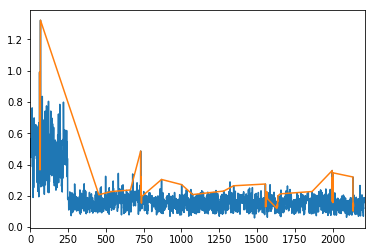

In [24]:
pd.Series(output).plot()
pd.Series(output)[foo].plot()

In [17]:
foo = [62, 63, 64, 65, 66, 67, 68, 454, 536, 663, 731, 732, 733, 734, 735, 736, 737, 738, 869, 1002, 1075, 1280, 1346, 1556, 1557, 1558, 1559, 1560, 1561, 1562, 1563, 1565, 1570, 1632, 1633, 1634, 1635, 1636, 1637, 1638, 1639, 1656, 1865, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2135, 2136, 2137, 2138, 2139]

In [ ]:
data